<img src="https://github.com/Sengsathit/OCR_data_scientist_assets/blob/main/header_seattle.png?raw=true" alt="Alternative text" />

**Table of contents**<a id='toc0_'></a>    
- [Introduction](#toc1_)    
- [1 - Importations et configurations](#toc2_)    
- [2 - Chargement des données et sélection de features](#toc3_)    
  - [Chargement du dataset](#toc3_1_)    
  - [Feature engineering](#toc3_2_)    
    - [Surface des usages primaires, secondaires et tertiaires](#toc3_2_1_)    
    - [Distance par rapport centre-ville](#toc3_2_2_)    
    - [Les types de voies](#toc3_2_3_)    
    - [Classes d'âge](#toc3_2_4_)    
    - [Proportion utilisation énergétique](#toc3_2_5_)    
    - [Nombre de buildings](#toc3_2_6_)    
  - [Sélection des features](#toc3_3_)    
- [3 - Preprocessing](#toc4_)    
    - [Fonctions ré-utilisables](#toc4_1_1_)    
    - [Suppression des outliers](#toc4_1_2_)    
    - [Séparation des données](#toc4_1_3_)    
    - [Pipelines](#toc4_1_4_)    
- [4 - Modélisation et évaluation](#toc5_)    
  - [Fonctions ré-utilisables](#toc5_1_)    
  - [Évaluation des modèles](#toc5_2_)    
    - [Baseline](#toc5_2_1_)    
    - [Autres modèles](#toc5_2_2_)    
- [5 - Recherche des hyper-paramètres](#toc6_)    
  - [Fonctions ré-utilisables](#toc6_1_)    
  - [Recherche des meilleurs paramètres](#toc6_2_)    
    - [Préparation des données de validation et de test](#toc6_2_1_)    
    - [Gradient Boost Regressor](#toc6_2_2_)    
    - [XGBoost Regressor](#toc6_2_3_)    
- [6 - Explication du modèle prédictif](#toc7_)    
  - [Préparation des données et de l'explainer SHAP](#toc7_1_)    
  - [Interprétation globale](#toc7_2_)    
  - [Interprétation locale](#toc7_3_)    
    - [Individu avec une valeur de rejet de CO2 médian](#toc7_3_1_)    
    - [Individu avec une valeur de rejet de CO2 la plus élevée](#toc7_3_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Introduction](#toc0_)

Dans ce travail, nous nous intéressons à la mise en place d'un modèle prédictif des émissions de CO2 pour les bâtiments de Seattle. À partir d'un ensemble de données comprenant diverses caractéristiques physiques et énergétiques des bâtiments, notre objectif est de développer un outil capable de prédire les émissions de gaz à effet de serre en fonction de ces variables.

# <a id='toc2_'></a>[1 - Importations et configurations](#toc0_)

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split, learning_curve
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import shap



# Configurer Pandas pour un affichage complet du contenu des colonnes
#pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

/var/folders/59/q0j81gmx5h7gvpg38k8hknzw0000gn/T/ipykernel_75918/3627215280.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Users/sengsathit/Apprentissages/OpenClassrooms/00_projets/OCR_data_scientist_projet_04/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# <a id='toc3_'></a>[2 - Chargement des données et sélection de features](#toc0_)

## <a id='toc3_1_'></a>[Chargement du dataset](#toc0_)

In [3]:
# Chargement du dataset initialement nettoyé
df_initial = pd.read_csv("../datasets/Seattle.csv")
df = df_initial.copy()

df.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity,Age
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,Unknown,0.0,Unknown,0.0,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,Compliant,249.98,2.83,89
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,Compliant,295.86,2.86,20
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,Unknown,0.0,Unknown,0.0,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,Compliant,2089.28,2.19,47
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,Unknown,0.0,Unknown,0.0,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,Compliant,286.43,4.67,90
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,False,Compliant,505.01,2.88,36


## <a id='toc3_2_'></a>[Feature engineering](#toc0_)

### <a id='toc3_2_1_'></a>[Surface des usages primaires, secondaires et tertiaires](#toc0_)

Nous mettons en place un processus de feature engineering concernant les types d'usages des propriétés. L'objectif est de créer des colonnes dédiées à chaque catégorie unique d'usage de propriété, qu'elle soit identifiée comme principale, secondaire ou tertiaire.

Pour chaque propriété, nous vérifions la présence du type d'usage dans les trois catégories (principale, secondaire, tertiaire) et nous assignons la surface correspondante (GFA - Gross Floor Area) à la colonne appropriée.

In [4]:
columns_to_fill = df["LargestPropertyUseType"].unique()
second_third = np.concatenate([df["SecondLargestPropertyUseType"].unique(), df["ThirdLargestPropertyUseType"].unique()])

for column in second_third:
    if column not in columns_to_fill:
        columns_to_fill = np.append(columns_to_fill, column)

# Fonction pour remplir les colonnes
def fill_columns(row, columns_to_fill):
    for column in columns_to_fill:
        if column == row["LargestPropertyUseType"]:
            return row["LargestPropertyUseTypeGFA"]
        elif column == row["SecondLargestPropertyUseType"]:
            return row["SecondLargestPropertyUseTypeGFA"]
        elif column == row["ThirdLargestPropertyUseType"]:
            return row["ThirdLargestPropertyUseTypeGFA"]
        else:
            return 0

# Remplir les colonnes avec les valeurs correspondantes
for column in columns_to_fill:
    df[column] = df.apply(lambda row: fill_columns(row, [column]), axis=1)

# Renommage des colonnes concernées
columns_mapping = {col: "PropertyUseType_" + col for col in columns_to_fill}
df = df.rename(columns=columns_mapping)

df.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity,Age,PropertyUseType_Hotel,PropertyUseType_Police Station,PropertyUseType_Other - Entertainment/Public Assembly,PropertyUseType_Library,PropertyUseType_Fitness Center/Health Club/Gym,PropertyUseType_Social/Meeting Hall,PropertyUseType_Courthouse,PropertyUseType_Other,PropertyUseType_College/University,PropertyUseType_Automobile Dealership,PropertyUseType_Self-Storage Facility,PropertyUseType_Office,PropertyUseType_Non-Refrigerated Warehouse,PropertyUseType_K-12 School,PropertyUseType_Other - Mall,PropertyUseType_Senior Care Community,PropertyUseType_Medical Office,PropertyUseType_Retail Store,PropertyUseType_Hospital (General Medical & Surgical),PropertyUseType_Museum,"PropertyUseType_Repair Services (Vehicle, Shoe, Locksmith, etc)",PropertyUseType_Other - Lodging/Residential,PropertyUseType_Residence Hall/Dormitory,PropertyUseType_Other/Specialty Hospital,PropertyUseType_Financial Office,PropertyUseType_Distribution Center,PropertyUseType_Parking,PropertyUseType_Worship Facility,PropertyUseType_Restaurant,PropertyUseType_Data Center,PropertyUseType_Laboratory,PropertyUseType_Supermarket/Grocery Store,PropertyUseType_Urgent Care/Clinic/Other Outpatient,PropertyUseType_Other - Services,PropertyUseType_Strip Mall,PropertyUseType_Wholesale Club/Supercenter,PropertyUseType_Refrigerated Warehouse,PropertyUseType_Manufacturing/Industrial Plant,PropertyUseType_Other - Recreation,PropertyUseType_Lifestyle Center,PropertyUseType_Other - Public Services,PropertyUseType_Fire Station,PropertyUseType_Performing Arts,PropertyUseType_Residential Care Facility,PropertyUseType_Bank Branch,PropertyUseType_Other - Education,PropertyUseType_Other - Restaurant/Bar,PropertyUseType_Food Service,PropertyUseType_Adult Education,PropertyUseType_Other - Utility,PropertyUseType_Movie Theater,"PropertyUseType_Personal Services (Health/Beauty, Dry Cleaning, etc)",PropertyUseType_Pre-school/Daycare,PropertyUseType_Prison/Incarceration,PropertyUseType_Unknown,PropertyUseType_Vocational School,PropertyUseType_Swimming Pool,PropertyUseType_Convenience Store without Gas Station,PropertyUseType_Enclosed Mall,PropertyUseType_Bar/Nightclub,PropertyUseType_Food Sales,PropertyUseType_Other - Technology/Science,PropertyUseType_Fast Food Restaurant
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,Unknown,0.0,Unknown,0.0,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,Compliant,249.98,2.83,89,88434.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,Compliant,295.86,2.86,20,8388

### <a id='toc3_2_2_'></a>[Distance par rapport centre-ville](#toc0_)

Dans cette section, nous développons une fonctionnalité permettant de quantifier la distance de chaque propriété par rapport au centre-ville de Seattle. Pour cela, nous employons la formule de Haversine pour calculer cette distance. 

Le résultat de cette fonction est ensuite stocké dans une nouvelle colonne du DataFrame, `DistanceFromCenter`, pour chaque propriété. Cette colonne reflète la distance en miles entre chaque propriété et le point central de Seattle.

In [5]:
from math import radians, cos, sin, asin, sqrt

# Fonction pour calculer la distance par rapport au centre de Seattle
def haversine_distance(lattitude, longitude, degrees=True):

    #Coordonnées du centre de Seattle
    seattle_latitude = 47.6062095
    seattle_longitude = -122.3320708

    r = 3956 # rayon de la Terre en miles
    
    if degrees:
        lattitude, longitude, seattle_latitude, seattle_longitude = map(radians, [lattitude, longitude, seattle_latitude, seattle_longitude])
    
    # Formule Haversine
    delta_lng = seattle_longitude - longitude 
    delta_lat = seattle_latitude - lattitude 
    a = sin(delta_lat/2)**2 + cos(lattitude) * cos(seattle_latitude) * sin(delta_lng/2)**2
    d = 2 * r * asin(sqrt(a))  

    return d

df["DistanceFromCenter"] = df[["Latitude", "Longitude"]].apply(lambda row: haversine_distance(row["Latitude"],row["Longitude"]),axis=1)

### <a id='toc3_2_3_'></a>[Les types de voies](#toc0_)

Nous normalisons les types de voies des adresses pour uniformiser les formats dans notre dataset : 

* Nous débutons par compiler une liste de types de voies qui inclut à la fois les formes abrégées et complètes, telles que "Street" et "St".
* Un dictionnaire de mappage, street_type_mapping, est utilisé pour convertir les abréviations en noms complets. Par exemple, "Ave" est systématiquement transformé en "Avenue".
* La fonction extract_and_normalize_street_type applique cette logique en recherchant chaque type de voie dans l'adresse.

Le résultat est stocké dans la nouvelle colonne `StreetType` du DataFrame, où chaque entrée reflète le type de voie normalisé extrait de son adresse respective.

In [6]:
import re

street_types = ["Way", "Avenue", "Street", "Ave", "St", "Road", "Rd", "Drive", "Dr", "Lane", "Ln", "Boulevard", "Blvd", "Place", "Pl", "Terrace", "Ter", "Court", "Ct", "Circle", "Cir"]

# Dictionnaire de mappage pour normaliser les types de voies
street_type_mapping = {
    "Ave": "Avenue",
    "St": "Street",
    "Rd": "Road",
    "Dr": "Drive",
    "Blvd": "Boulevard",
    "Pl": "Place",
    "Ln": "Lane"
}

# Mettre à jour la liste des types de voies pour inclure à la fois les formes longues et courtes
street_types = list(set(street_types + list(street_type_mapping.keys())))

# Créer une expression régulière pour rechercher ces types
street_type_regex = r"\b(?:" + "|".join(street_types) + r")\b"

# Fonction pour extraire et normaliser le type de voie de l"adresse
def extract_and_normalize_street_type(address):
    match = re.search(street_type_regex, address, re.IGNORECASE)
    if match:
        # Normaliser le type de voie
        street_type = match.group(0).title()
        return street_type_mapping.get(street_type, street_type)
    else:
        return None

df["StreetType"] = df["Address"].apply(extract_and_normalize_street_type)


### <a id='toc3_2_4_'></a>[Classes d'âge](#toc0_)

Nous classons les données d'âge dans des catégories prédéfinies. Nous utilisons la fonction pd.cut pour diviser les valeurs d'âge en intervalles spécifiques : 0-10, 10-20, 20-50, 50-100, et plus de 100 ans. À chaque intervalle correspond une étiquette numérique de 1 à 5.

La nouvelle colonne `AgeClass` dans notre DataFrame contient ces étiquettes afin de représenter facilement les tranches d'âge par des catégories simplifiées pour chaque entrée.

In [7]:
# Définition des intervalles et des étiquettes
bins = [0, 10, 20, 50, 100, float("inf")]
labels = [1, 2, 3, 4, 5]

# Création des étiquettes en fonction de l"âge
df["AgeClass"] = pd.cut(df["Age"], bins=bins, labels=labels, right=False).astype(int)

### <a id='toc3_2_5_'></a>[Proportion utilisation énergétique](#toc0_)

Nous calculons la proportion de différentes sources d'utilisation énergétique par rapport à l'usage total d'énergie du site. Ces ratios fournissent une vue détaillée de la dépendance de chaque propriété vis-à-vis des différentes sources d'énergie.

Trois nouvelles colonnes sont créées pour mesurer la part relative de la vapeur, de l'électricité et du gaz naturel dans la consommation énergétique totale de chaque propriété.

In [8]:
df["Ratio_SteamUse"] = df["SteamUse(kBtu)"] / df["SiteEnergyUse(kBtu)"]
df["Ratio_Electricity"] = df["Electricity(kBtu)"] / df["SiteEnergyUse(kBtu)"]
df["Ratio_NaturalGas"] = df["NaturalGas(kBtu)"] / df["SiteEnergyUse(kBtu)"]

### <a id='toc3_2_6_'></a>[Nombre de buildings](#toc0_)

Certaines propriétés ont un nombre de bâtiments à 0, nous supprimons simplement les observations concernées

In [9]:
indexes = df.loc[df["NumberofBuildings"] == 0].index
df.drop(indexes, inplace=True)

## <a id='toc3_3_'></a>[Sélection des features](#toc0_)

Ici la target est l'émission de GES des bâtiments

In [10]:
feature_target = "TotalGHGEmissions"

Nous avons initialement envisagé d'inclure les features dérivées des types d'utilisation des propriétés dans notre modèle. Cependant, après avoir évalué leur impact sur la performance du modèle, il s'est avéré qu'elles n'apportaient aucune amélioration significative voire une régression de la performance. Par conséquent, nous avons choisis d'exclure ces features spécifiques pour recentrer ainsi notre attention sur les variables qui montrent un réel impact.

In [11]:
# features_relevant = [
#     "TotalGHGEmissions",
#     "PrimaryPropertyType",
#     "Ratio_SteamUse",
#     "Ratio_Electricity",
#     "Ratio_NaturalGas",
#     "StreetType",
#     "ENERGYSTARScore"
# ]

# features_relevant = features_relevant + [col for col in df.columns if col.startswith("PropertyUseType_")]


Nous avons aussi initialement inclus diverses caractéristiques dans notre modèle, telles que :
* le nombre de bâtiments
* la classe d'âge
* la distance par rapport au centre-ville
* le quartier
* l'usage tertiaire des propriétés
* la surface dédiée à l'usage tertiaire

Toutefois, après validation et test, ces variables n'ont pas montré d'impact significatif sur la performance de notre modèle. En conséquence, nous avons décidé de ne pas les retenir dans notre ensemble de caractéristiques finales. Nous nous concentrons sur des indicateurs plus pertinents qui offrent une meilleure prédiction des résultats comme :
* le type principal de propriété
* l'utilisation des surfaces
* les ratios d'utilisation énergétique
* le score ENERGYSTAR

In [12]:
features_relevant = [
    feature_target,
    "PrimaryPropertyType",
    # "NumberofBuildings",
    # "AgeClass",
    # "DistanceFromCenter",
    # "Neighborhood",
    "LargestPropertyUseType",
    "LargestPropertyUseTypeGFA",
    "SecondLargestPropertyUseType",
    "SecondLargestPropertyUseTypeGFA",
    # "ThirdLargestPropertyUseType",
    # "ThirdLargestPropertyUseTypeGFA",
    "Ratio_SteamUse",
    "Ratio_Electricity",
    "Ratio_NaturalGas",
    "StreetType",
    "ENERGYSTARScore"
]

In [13]:
df = df[features_relevant]

df.sample(5)

,TotalGHGEmissions,PrimaryPropertyType,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,Ratio_SteamUse,Ratio_Electricity,Ratio_NaturalGas,StreetType,ENERGYSTARScore
1291,4.76,Small- and Mid-Sized Office,Office,20880.0,Unknown,0.0,0.0,1.000000,0.000000,Street,94.0
710,2.52,Small- and Mid-Sized Office,Office,13945.0,Parking,7238.0,0.0,1.000000,0.000000,Avenue,99.0
626,30.60,Mixed Use Property,Social/Meeting Hall,8969.0,Parking,8540.0,0.0,0.890824,0.109176,Avenue,NaN
1454,809.76,Other,Lifestyle Center,318986.0,Medical Office,19909.0,0.0,0.475023,0.524977,Street,NaN
1185,32.44,Other,Other,34733.0,Unknown,0.0,0.0,1.000000,0.000000,Way,NaN


# <a id='toc4_'></a>[3 - Preprocessing](#toc0_)

### <a id='toc4_1_1_'></a>[Fonctions ré-utilisables](#toc0_)

In [14]:
# Fonction pour récupérer les lignes contenant des outliers pour une variable donnée
def get_lines_with_outliers_for_column(df_to_check: pd.DataFrame, feature: str) -> pd.DataFrame:
    # Calcul des quartiles et de l"IQR
    Q1 = df_to_check[feature].quantile(0.25)
    Q3 = df_to_check[feature].quantile(0.75)
    IQR = Q3 - Q1
    # Bornes pour les outliers
    edge_low = Q1 - 1.5 * IQR
    edge_high = Q3 + 1.5 * IQR

    return df_to_check[(df_to_check[feature] < edge_low) | (df_to_check[feature] > edge_high)]

### <a id='toc4_1_2_'></a>[Suppression des outliers](#toc0_)

In [15]:
# Suppression des outliers de la target
indexes_to_delete = get_lines_with_outliers_for_column(df, feature_target).index

df.drop(indexes_to_delete, inplace=True)

df.shape

(1296, 11)

### <a id='toc4_1_3_'></a>[Séparation des données](#toc0_)

Nous constitution des ensembles de données d'entraînement et de test

In [16]:
X = df.drop(feature_target, axis=1)
y = df[feature_target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### <a id='toc4_1_4_'></a>[Pipelines](#toc0_)

Nous mettons en place une structure pour le prétraitement des données en utilisant des pipelines spécifiques pour les caractéristiques numériques et catégorielles. Ce système de préparation des données permet d'assurer que notre modèle de machine learning reçoive des entrées bien formatées, standardisées cela de manière automatisée.

Nous utilisons un ColumnTransformer pour appliquer sélectivement différentes transformations : la standardisation pour les variables numériques sélectionnées et l'encodage One-Hot pour les variables catégorielles.

In [17]:
numerical_features = make_column_selector(dtype_include="number")
categorical_features = make_column_selector(dtype_include="object")

# Features à exclure de la standardisation
excluded_numerical_features = make_column_selector(pattern="\
                                                   ^AgeClass|\
                                                   ^Ratio_SteamUse|\
                                                   ^Ratio_Electrivity|\
                                                   ^Ratio_NaturalGas"
                                                   )
# Features à standardiser
included_numerical_features = lambda x: [col for col in numerical_features(x) if col not in excluded_numerical_features(x)]

# Pipeline pour les features numériques à standardiser
numerical_pipeline = Pipeline([
    ("standard_scaling", StandardScaler())  # Application de la standardisation
])

# Pipeline pour les features catégorielles
categorical_pipeline = Pipeline([
    ("one_hot_encoding", OneHotEncoder(handle_unknown="ignore")),  # Encodage One-Hot
])

# Préprocesseur combiné pour le traitement des données
column_transformer = ColumnTransformer(
    transformers=[
        ("numerical", numerical_pipeline, included_numerical_features),
        ("categorical", categorical_pipeline, categorical_features)
    ]
)

# <a id='toc5_'></a>[4 - Modélisation et évaluation](#toc0_)

## <a id='toc5_1_'></a>[Fonctions ré-utilisables](#toc0_)

Nous établissons une série de fonctions conçues pour valider et tester l'efficacité de différents modèles de prédiction à travers des méthodes de validation croisée et de visualisation des courbes d'apprentissage. L'objectif est de comparer les performances des modèles avec et sans la prise en compte du score ENERGYSTAR.

La première fonction, `plot_learning_curve`, trace les courbes d'apprentissage pour un modèle donné en montrant comment les performances évoluent avec l'augmentation de la taille de l'ensemble d'entraînement.

Les deux autres fonctions, `cross_validate_test_models` et `validate_and_test_models`, effectuent des validations croisées et des tests pour évaluer la performance des modèles sous différents aspects tels que l'erreur absolue moyenne (MAE), l'erreur quadratique moyenne (RMSE), et le coefficient de détermination (R²). Ces fonctions comparent également l'impact de l'inclusion de l'ENERGYSTAR Score dans le modèle, en fournissant une analyse comparative pour aider à décider si cet indicateur doit être inclus dans le modèle final.

In [18]:
# Fonction de traçage des courbes d"apprentissage pour un modèle donné
def plot_learning_curve(model_to_validate, x_train_set, y_train_set, n_folds, scoring_method):

    # Courbes d'apprentissage avec ENERGY STAR score
    X_train_set_copy = x_train_set.copy()
    y_train_set_copy = y_train_set.copy()
    indexes_to_delete = X_train_set_copy[X_train_set_copy["ENERGYSTARScore"].isna()].index
    X_train_set_copy = X_train_set_copy.drop(indexes_to_delete, axis=0)
    y_train_set_copy = y_train_set_copy.drop(indexes_to_delete, axis=0)
    train_sizes_ess, train_scores_ess, test_scores_ess = learning_curve(
        model_to_validate, 
        X_train_set_copy, 
        y_train_set_copy, 
        cv=n_folds, 
        scoring=scoring_method, 
        n_jobs=-1, 
        train_sizes=np.linspace(.1, 1.0, 10)
    )

    # Courbes d'apprentissage sans ENERGY STAR score
    X_train_set_copy = x_train_set.copy()
    y_train_set_copy = y_train_set.copy()
    X_train_set_copy = X_train_set_copy.drop("ENERGYSTARScore", axis=1)
    train_sizes, train_scores, test_scores = learning_curve(
        model_to_validate, 
        X_train_set_copy, 
        y_train_set_copy, 
        cv=n_folds, 
        scoring=scoring_method, 
        n_jobs=-1, 
        train_sizes=np.linspace(.1, 1.0, 10)
    )

    model_name = (model_to_validate.steps[-1][0]).upper()
    
    plt.figure(figsize=(12,6))
    plt.title(f"Courbes d'apprentissage pour {model_name}")
    plt.ylabel("RMSE")
    plt.xlabel("Taille de l\'ensemble d\'entraînement")
    plt.plot(train_sizes_ess, -train_scores_ess.mean(axis=1), label="Train (avec ENERGY STAR)")
    plt.plot(train_sizes_ess, -test_scores_ess.mean(axis=1), label="Validation (avec ENERGY STAR)")
    plt.plot(train_sizes, -train_scores.mean(axis=1), label="Train")
    plt.plot(train_sizes, -test_scores.mean(axis=1), label="Validation")
    plt.legend()
    plt.show()


# Fonction de validation croisée pour des modèles donnés
def cross_validate_test_models(models_to_validate, x_train_set, y_train_set, n_folds, x_test_set, y_test_set):

    results_list = []

    with_energystar_score = "ENERGYSTARScore" in x_train_set.columns

    for model in models_to_validate:

        X_train_copy = x_train_set.copy()
        y_train_copy = y_train_set.copy()

        X_test_copy = x_test_set.copy()
        y_test_copy = y_test_set.copy()
        
        # Cross Validation
        stats_cv = y_train_copy.describe()
        scores_cv = cross_validate(model, X_train_copy, y_train_copy, cv=n_folds, scoring=("r2", "neg_root_mean_squared_error", "neg_mean_absolute_error"), return_train_score=False)
        mae_cv = np.mean(-scores_cv["test_neg_mean_absolute_error"])
        rmse_cv = np.mean(-scores_cv["test_neg_root_mean_squared_error"])
        rmse_mean_cv = rmse_cv/stats_cv["mean"]
        r2_cv = np.mean(scores_cv["test_r2"])

        # Test
        stats_test = y_train_copy.describe()
        model.fit(X_train_copy, y_train_copy)
        y_test_pred = model.predict(X_test_copy)
        mae_test = mean_absolute_error(y_test_copy, y_test_pred)
        rmse_test = np.sqrt(mean_squared_error(y_test_copy, y_test_pred))
        rmse_mean_test = rmse_test/stats_test["mean"]
        r2_test = r2_score(y_test_copy, y_test_pred)

        model_name = model.steps[-1][0]
        results_list.append([model_name, with_energystar_score, mae_cv, rmse_cv, rmse_mean_cv, r2_cv, mae_test, rmse_test, rmse_mean_test, r2_test])

    
    print("Stats de la target (avec ENERGYSTAR Score)" if with_energystar_score else "Stats de la target")
    print(f"________________________")
    print(f"{stats_cv}\n")

    return pd.DataFrame(
        columns=["Modèle", "ENERGYSTAR Score", "MAE (cv)", "RMSE (cv)", "RMSE/mean (cv)", "R² (cv)", "MAE (test)", "RMSE (test)", "RMSE/mean (test)", "R² (test)"],
        data=results_list
    )


# Fonction de validation croisée pour des modèles données
def validate_and_test_models(models_to_validate, x_train_set, y_train_set, n_folds, x_test_set, y_test_set):

    # Valider et tester les modèles sans ENERGY STAR score
    X_train_copy = x_train_set.copy()
    X_test_copy = x_test_set.copy()
    y_train_copy = y_train_set.copy()
    y_test_copy = y_test_set.copy()

    X_train_copy = X_train_copy.drop("ENERGYSTARScore", axis=1)
    X_test_copy = X_test_copy.drop("ENERGYSTARScore", axis=1)
    
    results_without_energystar = cross_validate_test_models(models_to_validate, X_train_copy, y_train_copy, n_folds, X_test_copy, y_test_copy)

    # Valider et tester les modèles avec ENERGY STAR score
    X_train_copy = x_train_set.copy()
    X_test_copy = x_test_set.copy()
    y_train_copy = y_train_set.copy()
    y_test_copy = y_test_set.copy()
    
    indexes_to_delete = x_train_set[x_train_set["ENERGYSTARScore"].isna()].index
    X_train_copy = X_train_copy.drop(indexes_to_delete, axis=0)
    y_train_copy = y_train_copy.drop(indexes_to_delete, axis=0)

    indexes_to_delete = x_test_set[x_test_set["ENERGYSTARScore"].isna()].index
    X_test_copy = X_test_copy.drop(indexes_to_delete, axis=0)
    y_test_copy = y_test_copy.drop(indexes_to_delete, axis=0)
    results_with_energystar = cross_validate_test_models(models_to_validate, X_train_copy, y_train_copy, n_folds, X_test_copy, y_test_copy)

    results = pd.concat([results_with_energystar, results_without_energystar], axis=0, ignore_index=True)

    display(results.sort_values("RMSE (test)"))

## <a id='toc5_2_'></a>[Évaluation des modèles](#toc0_)

### <a id='toc5_2_1_'></a>[Baseline](#toc0_)

Pour établir une référence initiale dans notre analyse prédictive, nous commençons par implémenter un modèle de régression linéaire pour comprendre les relations linéaires entre les variables. Ce modèle nous sert de baseline et nous permettra d'évaluer la performance des approches plus complexes que nous pourrions envisager par la suite.

Stats de la target
________________________
count    1036.000000
mean       73.484662
std        78.441600
min         0.000000
25%        18.997500
50%        42.245000
75%       101.357500
max       334.150000
Name: TotalGHGEmissions, dtype: float64

Stats de la target (avec ENERGYSTAR Score)
________________________
count    700.000000
mean      73.758557
std       77.829807
min        0.000000
25%       19.245000
50%       42.115000
75%      103.730000
max      328.630000
Name: TotalGHGEmissions, dtype: float64



,Modèle,ENERGYSTAR Score,MAE (cv),RMSE (cv),RMSE/mean (cv),R² (cv),MAE (test),RMSE (test),RMSE/mean (test),R² (test)
0,linear_regression,True,32.077506,47.738500,0.647227,0.618238,28.075981,39.379287,0.533894,0.659155
1,linear_regression,False,37.893909,57.152393,0.777746,0.460831,33.096674,44.913198,0.611191,0.528456


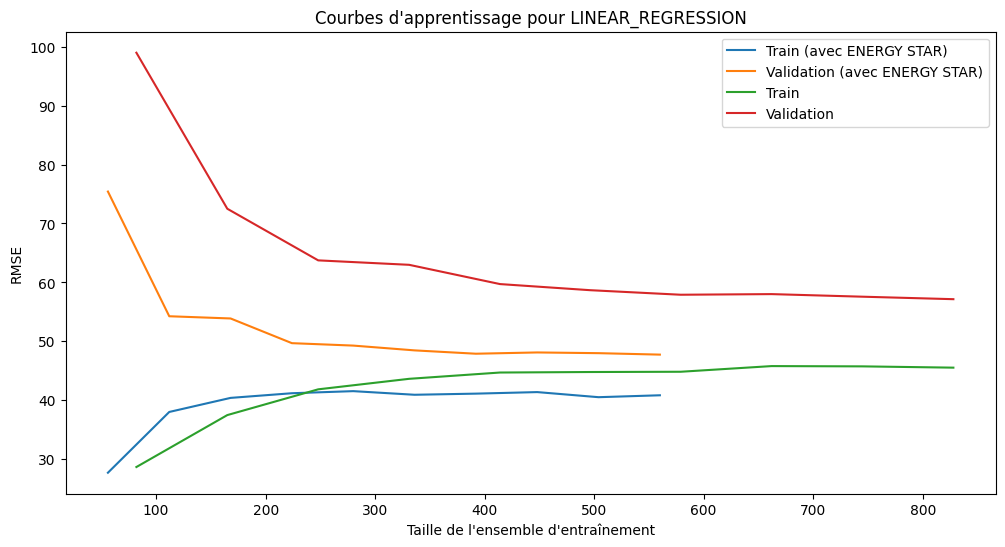

In [19]:
linear_model = Pipeline(
    steps=[
        ("preprocessor", column_transformer), 
        ("linear_regression", LinearRegression())
    ]
)

n_folds=5
validate_and_test_models([linear_model], X_train, y_train, n_folds, X_test, y_test)
plot_learning_curve(linear_model, X_train, y_train, n_folds, "neg_root_mean_squared_error")

### <a id='toc5_2_2_'></a>[Autres modèles](#toc0_)

Après avoir établi une baseline avec le modèle de régression linéaire, nous procédons à des tests avec une gamme plus large de modèles de machine learning pour identifier l'approche la plus efficace. Parmi les modèles testés figurent :
* des régularisations linéaires telles que `Ridge`, `Lasso` et `ElasticNet`
* des modèles plus sophistiqués incluant le `SVR`
* des modèles de bagging comme `RandomForestRegressor`
* des modèles de boosting comme `GradientBoostingRegressor` et `XGBoostRegressor`.

Chaque modèle est intégré dans un pipeline comprenant une étape de prétraitement et l'application du modèle spécifique. Ces modèles sont évalués en utilisant une validation croisée à cinq plis. 

Les courbes d'apprentissage de chaque modèle sont également tracées pour visualiser l'efficacité de l'apprentissage en fonction de la taille de l'ensemble d'entraînement, en utilisant le RMSE comme métrique d'évaluation.

Stats de la target
________________________
count    1036.000000
mean       73.484662
std        78.441600
min         0.000000
25%        18.997500
50%        42.245000
75%       101.357500
max       334.150000
Name: TotalGHGEmissions, dtype: float64

Stats de la target (avec ENERGYSTAR Score)
________________________
count    700.000000
mean      73.758557
std       77.829807
min        0.000000
25%       19.245000
50%       42.115000
75%      103.730000
max      328.630000
Name: TotalGHGEmissions, dtype: float64



,Modèle,ENERGYSTAR Score,MAE (cv),RMSE (cv),RMSE/mean (cv),R² (cv),MAE (test),RMSE (test),RMSE/mean (test),R² (test)
1,gradient_boosting_regressor,True,23.788351,38.685059,0.524482,0.750148,19.845175,29.228400,0.396271,0.812228
0,xgboost_regressor,True,23.238536,39.240427,0.532012,0.741984,19.814809,33.226107,0.450471,0.757350
2,random_forest_regressor,True,23.956642,39.876457,0.540635,0.734153,21.574796,33.535303,0.454663,0.752813
3,ridge,True,31.633146,47.219041,0.640184,0.626846,27.736846,38.720148,0.524958,0.670470
8,gradient_boosting_regressor,False,31.077250,47.713993,0.649305,0.626726,27.018280,39.571920,0.538506,0.633943
4,lasso,True,32.090615,48.234754,0.653955,0.611336,28.599663,39.594695,0.536815,0.655416
9,random_forest_regressor,False,30.878390,49.410058,0.672386,0.599895,26.605944,41.957377,0.570968,0.588480
10,ridge,False,36.526662,54.644299,0.743615,0.509442,31.782603,43.007354,0.585256,0.567626
7,xgboost_regressor,False,31.965816,49.908660,0.679171,0.589941,28.549663,44.028995,0.599159,0.546840
11,lasso,False,37.482151,55.300424,0.752544,0.498462,32.535674,44.574695,0.606585,0.535537


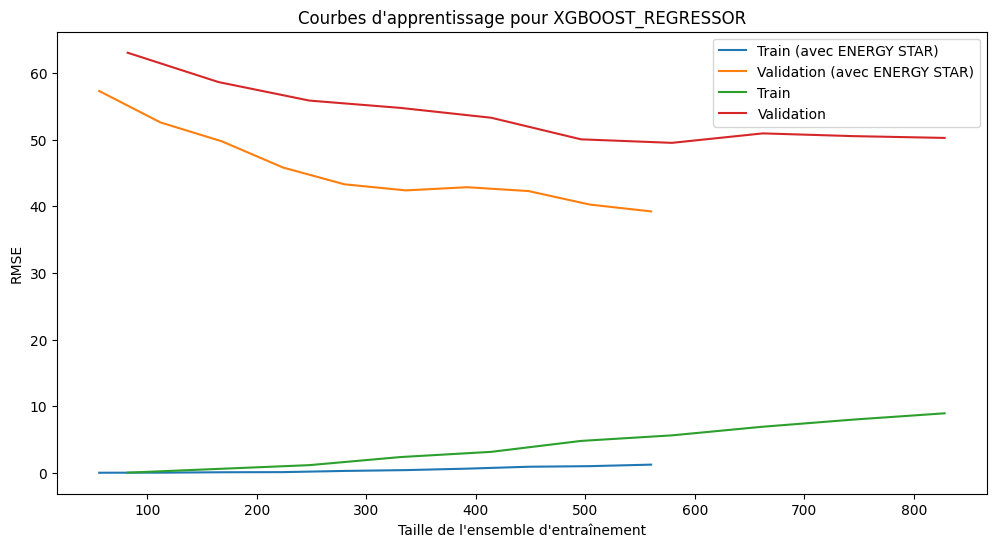

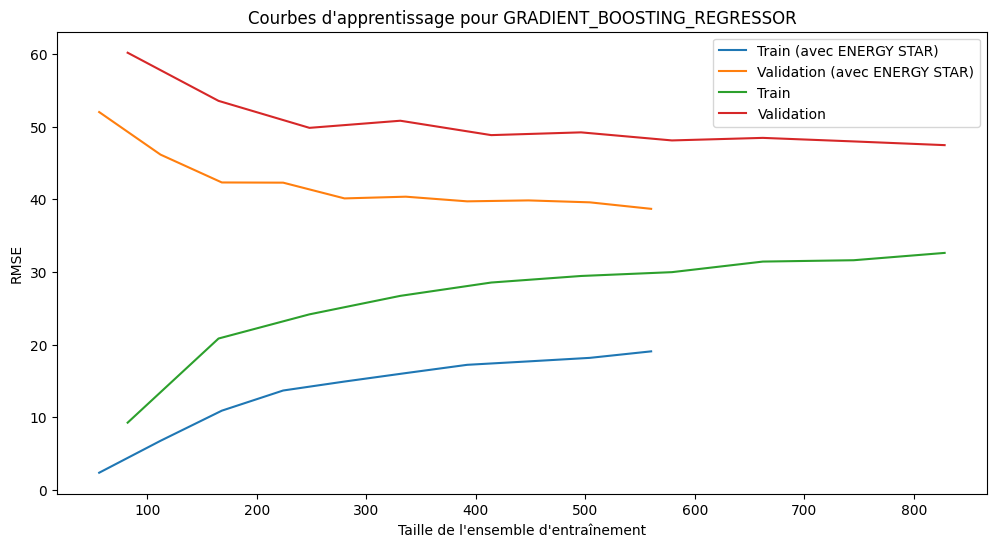

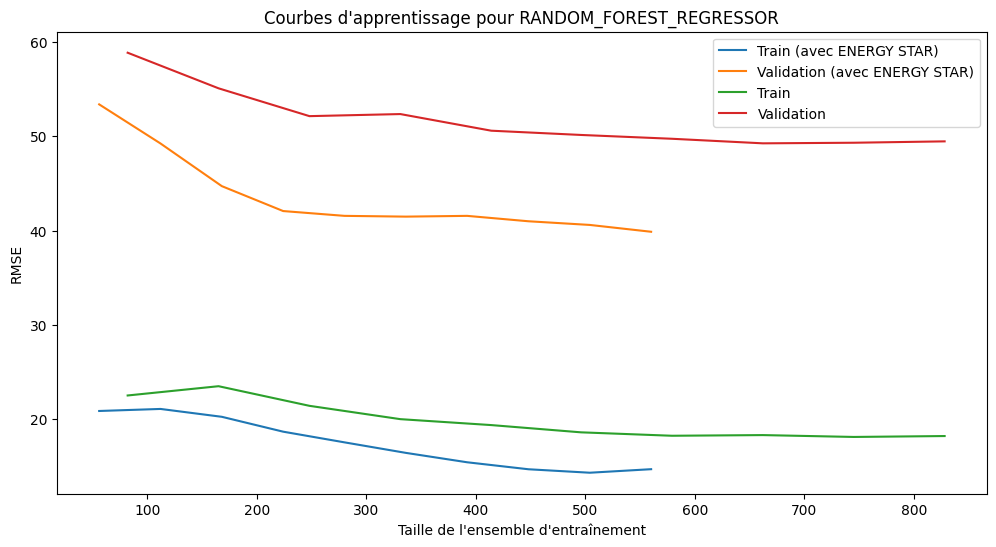

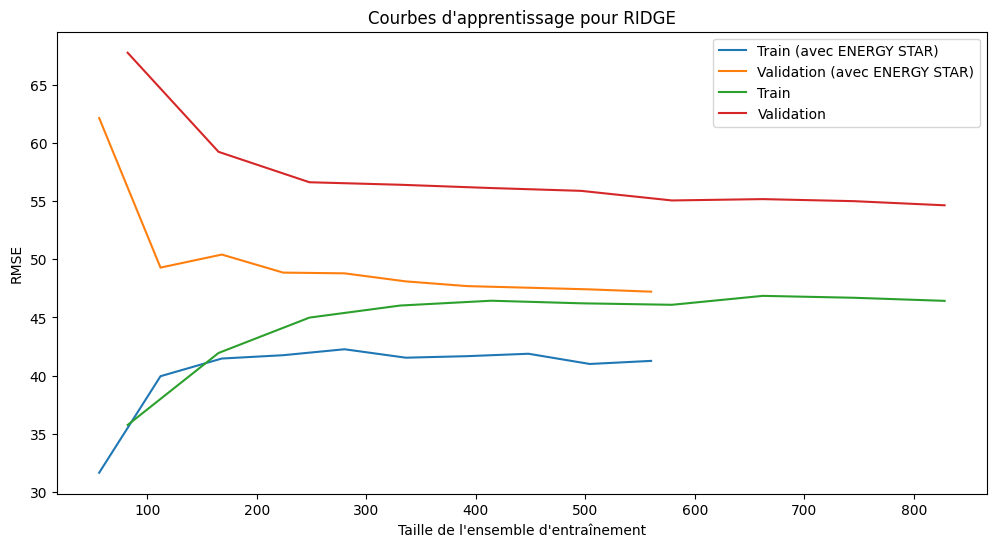

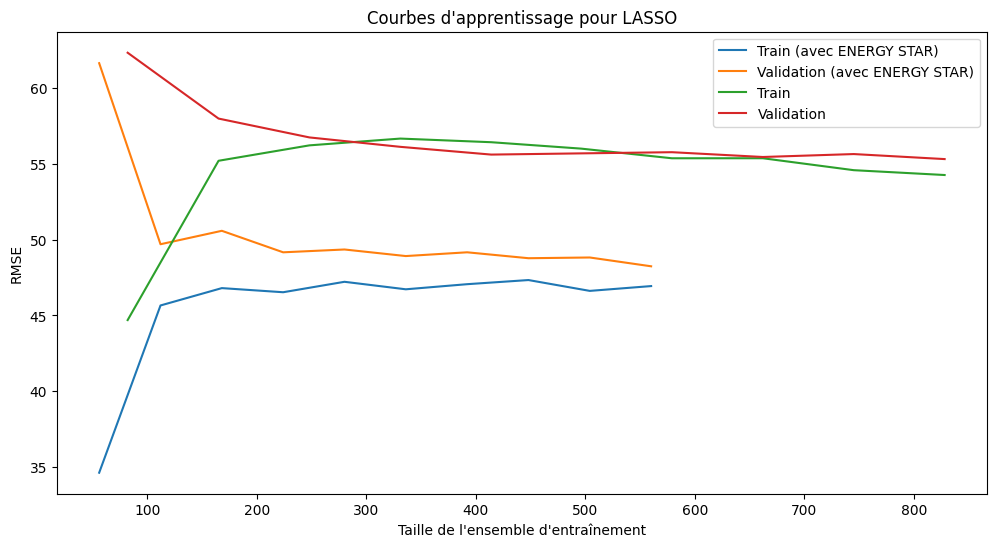

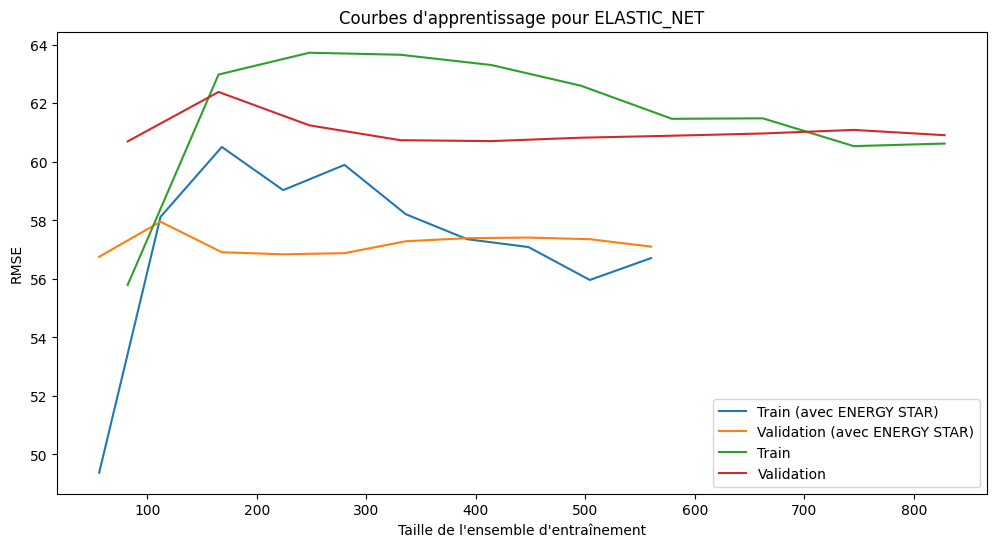

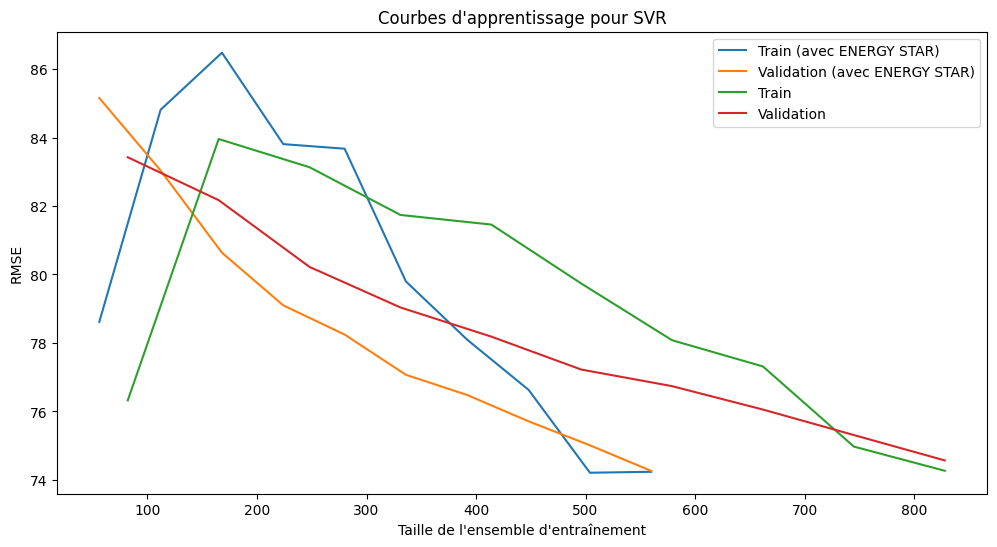

In [20]:
# Modèles finaux à évaluer et à tester

ridge_model = Pipeline(
    steps=[
        ("preprocessor", column_transformer),
        ("ridge", Ridge(random_state=42))
    ]
)

lasso_model = Pipeline(
    steps=[
        ("preprocessor", column_transformer),
        ("lasso", Lasso(random_state=42))
    ]
)
    
elastic_net_model = Pipeline(
    steps=[
        ("preprocessor", column_transformer),
        ("elastic_net", ElasticNet(random_state=42))
    ]
)

svr_model = Pipeline(
    steps=[
        ("preprocessor", column_transformer), 
        ("svr", SVR())
    ]
)

random_forest_regressor_model = Pipeline(
    steps=[
        ("preprocessor", column_transformer), 
        ("random_forest_regressor", RandomForestRegressor(random_state=42))
    ]
)

gradient_boosting_regressor_model = Pipeline(
    steps=[
        ("preprocessor", column_transformer), 
        ("gradient_boosting_regressor", GradientBoostingRegressor(random_state=42))
    ]
)

xgboost_regressor_model = Pipeline(
    steps=[
        ("preprocessor", column_transformer),
        ("xgboost_regressor", XGBRegressor(random_state=42))
    ]
)

models = [
    xgboost_regressor_model,
    gradient_boosting_regressor_model,
    random_forest_regressor_model,
    ridge_model, 
    lasso_model, 
    elastic_net_model, 
    svr_model, 
]

n_folds = 5

validate_and_test_models(models, X_train, y_train, n_folds, X_test, y_test)

for model in models:
    plot_learning_curve(model, X_train, y_train, n_folds, "neg_root_mean_squared_error")

# <a id='toc6_'></a>[5 - Recherche des hyper-paramètres](#toc0_)

Les résultats des Cross-Validation et des test précédents montrent clairement que les deux premiers modèles de boosting, le Gradient Boosting Regressor et le XGBoost Regressor, affichent des performances prometteuses. Ces deux modèles, enregistrant les meilleures valeurs en termes de RMSE et de R², notamment dans les configurations où le score ENERGYSTAR est inclus, seront donc sélectionnés pour une optimisation plus poussée de leurs paramètres. L'objectif sera de maximiser encore davantage leur efficacité en affinant leurs configurations puis de choisir un modèle final parmi ces deux modèles de boosting.

Nous insistons sur l'impact du score ENERGYSTAR car les performances des modèles est indéniable lorsque ces derniers tiennent compte de cette variable. En effet, avec elle, les modèles montrent une amélioration significative dans tous les indicateurs clés de performance, notamment une réduction notable des erreurs de prédiction et une augmentation de la variance expliquée (R²).

## <a id='toc6_1_'></a>[Fonctions ré-utilisables](#toc0_)

Nous mettons en place une fonction qui va permettre d'automatiser la recherche des hyperparamètres de nos modèles. Cette fonction, `search_best_estimator`, utilise `GridSearchCV` à 5 plis.

La fonction commence par exécuter le `GridSearchCV` sur l'ensemble d'entraînement pour identifier les meilleurs paramètres et le meilleur modèle. Une fois les meilleurs paramètres trouvés, elle les affiche.

Ensuite, la fonction évalue le modèle optimisé en utilisant des métriques standard telles que la MAE, la RMSE, le ratio RMSE par rapport à la moyenne des valeurs cibles et le coefficient de détermination (R²). Ces évaluations fournissent des mesures de performance qui aident à vérifier l'efficacité du modèle.

Enfin, la fonction retourne l'estimateur le mieux ajusté, prêt à être utilisé pour des prédictions futures ou des analyses plus approfondies.

In [21]:
# Fonction pour rechercher les meilleurs paramètres d'un modèle
def search_best_estimator(model, params, X_train_param, y_train_param, X_test_param, y_test_param):
    # Grids
    grid = GridSearchCV(model, params, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
    grid.fit(X_train_param, y_train_param)

    # Meilleurs paramètres et meilleur modèle
    model_name = (model.steps[-1][0]).upper()
    print(f"Meilleurs paramètres pour {model_name}")
    print(f"_" * 100)
    for param, value in grid.best_params_.items():
        print(f"{param.split("__")[-1]}: {value}")

    best_estimator = grid.best_estimator_

    scores = cross_validate(model, X_train_param, y_train_param, cv=5, scoring=("r2", "neg_root_mean_squared_error", "neg_mean_absolute_error"), return_train_score=False)
    mae_cv = np.mean(-scores["test_neg_mean_absolute_error"])
    rmse_cv = np.mean(-scores["test_neg_root_mean_squared_error"])
    rmse_mean_cv = rmse_cv/y_train_param.describe()["mean"]
    r2_cv = np.mean(scores["test_r2"])

    y_test_pred = best_estimator.predict(X_test_param)
    mae_test = mean_absolute_error(y_test_param, y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test_param, y_test_pred))
    rmse_mean_test = rmse_test/y_test_param.describe()["mean"]
    r2_test = r2_score(y_test_param, y_test_pred)

    display(pd.DataFrame(
        columns=["MAE (cv)", "RMSE (cv)", "RMSE/mean (cv)", "R² (cv)", "MAE (test)", "RMSE (test)", "RMSE/mean (test)", "R² (test)"],
        data=[[mae_cv, rmse_cv, rmse_mean_cv, r2_cv, mae_test, rmse_test, rmse_mean_test, r2_test]]
    ))

    return best_estimator
    

## <a id='toc6_2_'></a>[Recherche des meilleurs paramètres](#toc0_)

Les résultats de l'optimisation des hyperparamètres pour les modèles de Gradient Boosting Regressor et XGBoost Regressor révèlent que le XGBoost Regressor surpasse le Gradient Boosting Regressor après l'ajustement de certains paramètres. 

Pour le XGBoost, les meilleurs paramètres identifiés grâce à la `GridSearchCV` incluent :
* un taux d'apprentissage (learning rate) de 0.05
* une profondeur maximale (max depth) de 5
* un nombre d'estimateurs de 650
* colsample_bytree de 0.9
* un taux de sous-échantillonnage des exemples (subsample) de 0.6

Ces paramètres ont conduit à des performances avec un coefficient de détermination R² de 0.854998 pour les données de test. Ceci indique que le modèle ajusté explique environ 85.5% de la variabilité de la réponse. En outre, le RMSE sur les données de test montrent une précision accrue avec un score de 25.6848, qui est relativement bas par rapport à la moyenne de la cible, comme le montre le ratio RMSE/moyenne de 0.378083.

### <a id='toc6_2_1_'></a>[Préparation des données de validation et de test](#toc0_)

In [22]:
# Nous tenons compte des valeurs de ENERGYSTARScore
indexes_to_delete = X_train[X_train["ENERGYSTARScore"].isna()].index
X_train_copy = X_train.copy().drop(indexes_to_delete, axis=0)
y_train_copy = y_train.copy().drop(indexes_to_delete, axis=0)

indexes_to_delete = X_test[X_test["ENERGYSTARScore"].isna()].index
X_test_copy = X_test.copy().drop(indexes_to_delete, axis=0)
y_test_copy = y_test.copy().drop(indexes_to_delete, axis=0)

### <a id='toc6_2_2_'></a>[Gradient Boost Regressor](#toc0_)

In [23]:
# Grilles des paramètres pour Gradient Boost Regressor
params = {
    "gradient_boosting_regressor__n_estimators": [250, 300, 350], 
    "gradient_boosting_regressor__learning_rate": [0.05, 0.1, 0.15], 
    "gradient_boosting_regressor__max_depth": [2, 3]
}

best_estimator_for_gradient_boosting_regressor = search_best_estimator(gradient_boosting_regressor_model, params, X_train_copy, y_train_copy, X_test_copy, y_test_copy)

Meilleurs paramètres pour GRADIENT_BOOSTING_REGRESSOR
____________________________________________________________________________________________________
learning_rate: 0.1
max_depth: 3
n_estimators: 300


,MAE (cv),RMSE (cv),RMSE/mean (cv),R² (cv),MAE (test),RMSE (test),RMSE/mean (test),R² (test)
0,23.788351,38.685059,0.524482,0.750148,18.195982,26.743388,0.393665,0.842799


### <a id='toc6_2_3_'></a>[XGBoost Regressor](#toc0_)

In [24]:
# Grilles de paramètres pour XGBoost Regressor
params = {
    "xgboost_regressor__n_estimators": [600, 650, 700, 750],
    "xgboost_regressor__learning_rate": [0.01, 0.02, 0.05],
    "xgboost_regressor__max_depth": [4, 5, 6],
    "xgboost_regressor__subsample": [0.5, 0.6, 0.7],
    "xgboost_regressor__colsample_bytree": [0.8, 0.9, 1.0]
}

best_estimator_for_xgboost_regressor = search_best_estimator(xgboost_regressor_model, params, X_train_copy, y_train_copy, X_test_copy, y_test_copy)

Meilleurs paramètres pour XGBOOST_REGRESSOR
____________________________________________________________________________________________________
colsample_bytree: 0.9
learning_rate: 0.05
max_depth: 5
n_estimators: 650
subsample: 0.6


,MAE (cv),RMSE (cv),RMSE/mean (cv),R² (cv),MAE (test),RMSE (test),RMSE/mean (test),R² (test)
0,23.238536,39.240427,0.532012,0.741984,16.886635,25.6848,0.378083,0.854998


# <a id='toc7_'></a>[6 - Explication du modèle prédictif](#toc0_)

## <a id='toc7_1_'></a>[Préparation des données et de l'explainer SHAP](#toc0_)

In [25]:
preprocessor = best_estimator_for_xgboost_regressor.named_steps["preprocessor"]
features_names = [name.split("__")[-1] for name in preprocessor.get_feature_names_out()]
model = best_estimator_for_xgboost_regressor.named_steps["xgboost_regressor"]

X_train_transformed = preprocessor.transform(X_train_copy)
X_test_transformed = preprocessor.transform(X_test_copy)
X_train_df = pd.DataFrame(X_train_transformed.toarray(), columns=features_names, index=X_train_copy.index)
X_test_df = pd.DataFrame(X_test_transformed.toarray(), columns=features_names, index=X_test_copy.index)

explainer = shap.Explainer(model, X_train_df)
shap_values = explainer(X_test_df)

## <a id='toc7_2_'></a>[Interprétation globale](#toc0_)

Le modèle valorise particulièrement l'efficacité énergétique des propriétés. En effet,de manière significative, le ratio de gaz naturel et d'électricité, sont les plus influentes, ceci suggère que la performance énergétique est un facteur déterminant. 

Les caractéristiques concernant les surfaces utilisées des propriétés (GFA de la plus grande et de la deuxième plus grande utilisation) montrent également une influence notable.

En revanche, un grand nombre de caractéristiques additionnelles semblent avoir peu ou pas d'impact, ce qui souligne la concentration de l'importance sur quelques variables clés dans le modèle. Par exemple, certaines caractéristiques spécifiques à des types d’établissements (écoles, banques, centres de données etc...) n'ont aucune influence apparente. Ceci indique que le modèle est moins sensible au type de propriété qu'à la gestion et à l'utilisation des ressources énergétiques.

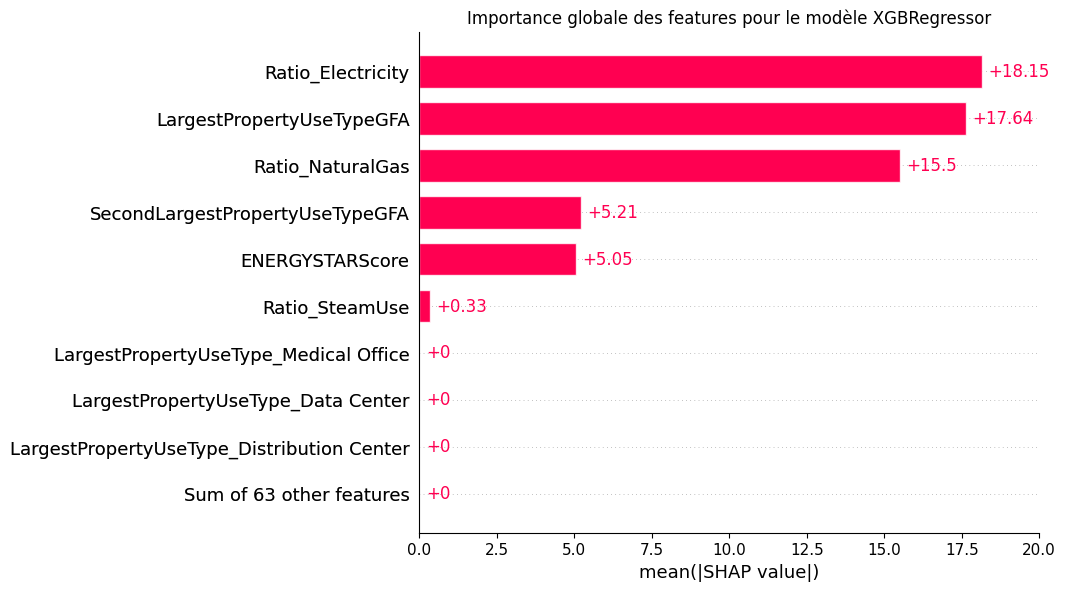

In [26]:
plt.title("Importance globale des features pour le modèle XGBRegressor")
shap.plots.bar(shap_values)

Pour le graphique suivant nous pouvons émettre les constats :

* `Ratio_Electricity` et `LargestPropertyUseTypeGFA` montrent une grande variabilité et semblent avoir à la fois des impacts positifs et négatifs importants sur les prédictions. Cela suggère que selon la quantité d'électricité utilisée ou la superficie du type d'utilisation de propriété principal, l'impact sur les émissions de CO2 peut varier considérablement.

* `Ratio_NaturalGas` présente majoritairement des valeurs basse et impact négativement le modèle. Ceci indique que des valeurs basse de cette caractéristique tendent à diminuer les émissions de CO2 prédites.

* `ENERGYSTARScore` présente un impact mixte avec des points principalement centrés autour de zéro mais légèrement négatifs, ce qui suggère que des scores plus élevés (meilleure performance énergétique) sont généralement associés à de faibles émissions de CO2

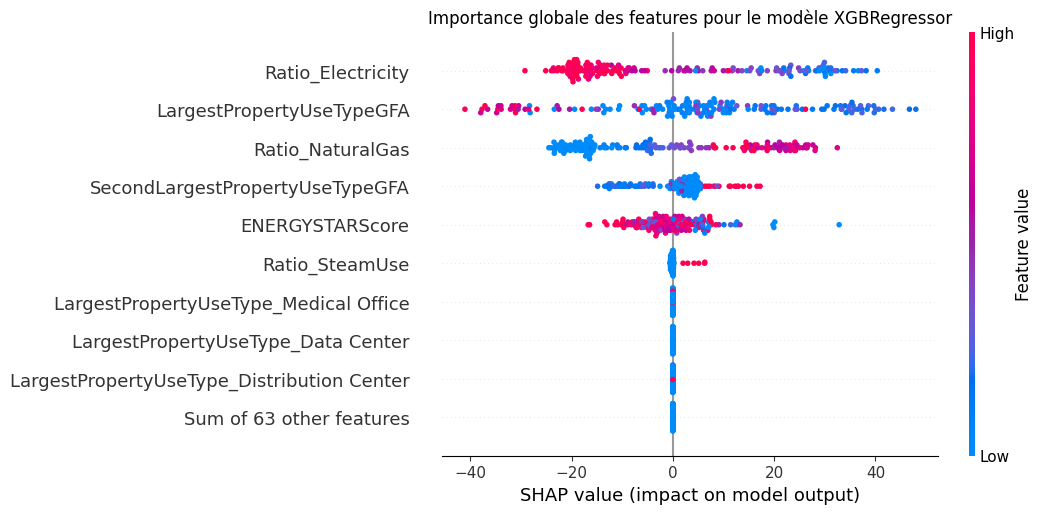

In [27]:
plt.title("Importance globale des features pour le modèle XGBRegressor")
shap.plots.beeswarm(shap_values)

## <a id='toc7_3_'></a>[Interprétation locale](#toc0_)

### <a id='toc7_3_1_'></a>[Individu avec une valeur de rejet de CO2 médian](#toc0_)

Pour l'individu étudié, nous constatons que les caractéristiques les plus influentes incluent le `Ratio_Electricity` et le `Ratio_NaturalGas`. Le constat est le suivant : 
* une consommation plus élevée d'électricité semble contribuer à une réduction significative des émissions (effet négatif de -14.88)
* une consommation moins élevée de gaz naturel montre aussi une contribution négative aux prédictions du modèle (effet négatif de -10.44). 

De plus, la surface de la plus grande utilisation de la propriété (`LargestPropertyUseTypeGFA`) influence positivement les émissions, indiquant que les propriétés plus grandes peuvent être associées à des émissions plus élevées.

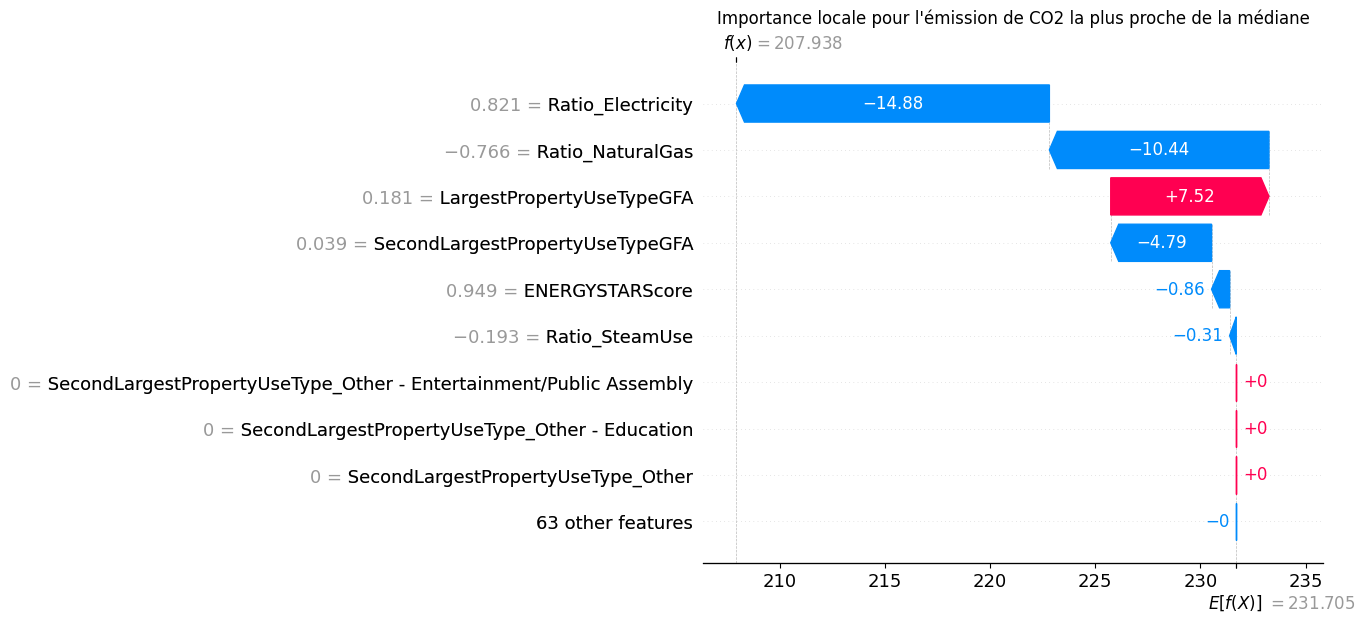

In [28]:
Q2 = y_test_copy.quantile(0.5) # Médiane
obs_Q2_index = y_test_copy.iloc[(y_test_copy - Q2).abs().argsort()[:1]].index # Index de l'observation la plus proche de la médiane
obs_Q2_loc = y_test_copy.index.get_loc(obs_Q2_index[0]) # Localisation de l'observation la plus proche de la médiane

plt.title("Importance locale pour l'émission de CO2 la plus proche de la médiane")
shap.plots.waterfall(shap_values[obs_Q2_loc])

### <a id='toc7_3_2_'></a>[Individu avec une valeur de rejet de CO2 la plus élevée](#toc0_)

Pour cet individu, on observe que la surface de l'utilisation principale de la propriété a l'impact le plus significatif sur l'augmentation des émissions, ajoutant 34.22 unités à la prédiction. Cela indique qu'une surface élevée est fortement associée à des émissions accrues de CO2 pour cet individu.

De même, `Ratio_Electricity` et `Ratio_NaturalGas` ont également un effet notable, contribuant à augmenter la prédiction respectivement de 24.82 et de 20.17 unités. Cela suggère que, pour cet individu, l'utilisation de l'électricité et la consommation de gaz naturel est également un facteur important d'augmentation des émissions de CO2.

En outre, un score ENERGYSTAR plus faible ajoute 7.04 unités à la prédiction, ce qui implique que moins ce score est élevé énergétique plus les émissions de GES sont élevées.

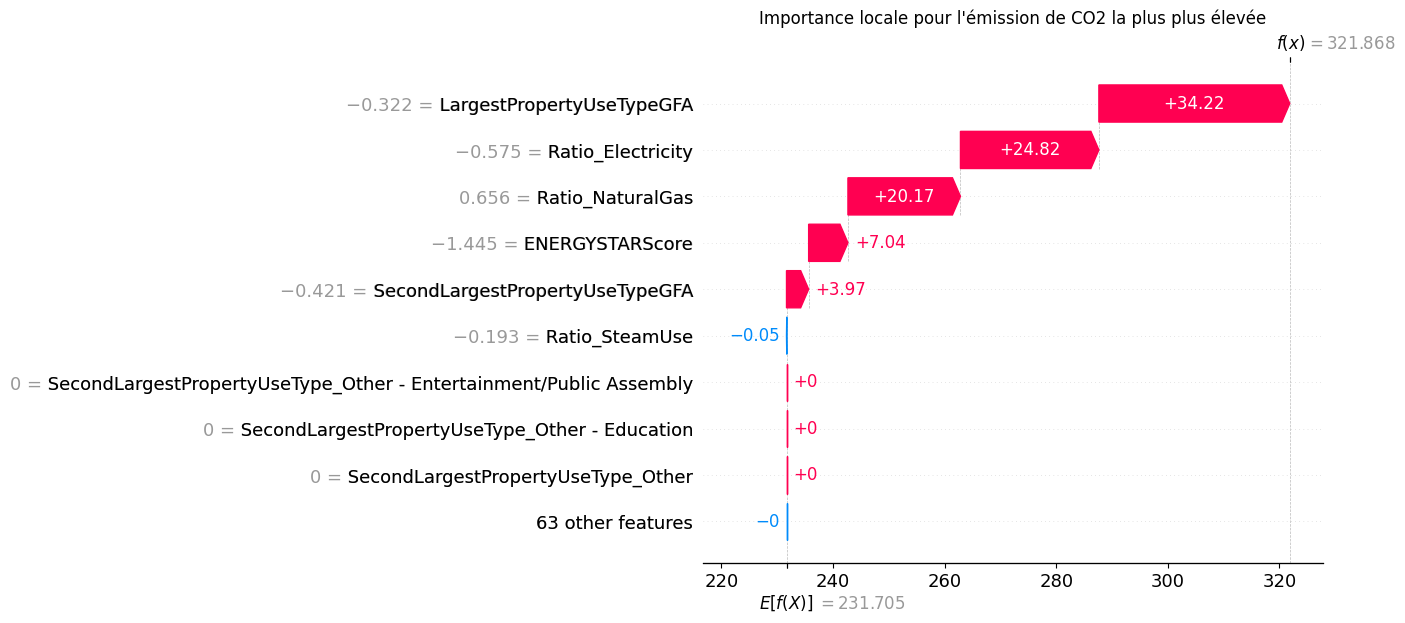

In [29]:
max_val = y_test_copy.max()
obs_max_index = y_test_copy.iloc[(y_test_copy - max_val).abs().argsort()[:1]].index  # Index de l'observation la plus proche de la valeur maximale de la target
obs_max_loc = y_test_copy.index.get_loc(obs_max_index[0]) # Index de l'observation la plus proche de la valeur maximale de la target

plt.title("Importance locale pour l'émission de CO2 la plus plus élevée")
shap.plots.waterfall(shap_values[obs_max_loc])